# Select practices prescibing nimodipine meeting eligibility criteria

## 1. Import all nimodipine data, filtering out closed and small practices

In [23]:

# Set dates of baseline and follow-up periods
d5 = '2020-03-01' # month after end of follow-up period (6 months)
d4 = '2019-09-01' # follow-up start
d3 = '2019-04-01' # month after end of baseline period
d2 = '2019-01-01' # start of 3-month baseline period
d1 = '2018-04-01' # start of 12-month baseline period


# import data for all practices prescribing nimodipine, 
# excluding those which are dormant/closed,
# excluding practices which are not standard general practices
# excluding practices in Devon CCG (or one of its predecessor organisations NEW Devon CCG)

# Import dataset from BigQuery
import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

q = '''
WITH a AS (
SELECT * FROM 
`ebmdatalab.hscic.normalised_prescribing_standard` 
WHERE SUBSTR(bnf_code,1,9) = '0206020M0'
AND EXTRACT(year FROM month) > 2017 )

SELECT  
    a.practice,
    a.pct,
    setting,
    a.month,
    total_list_size,
    SUM(a.items) AS items,
    SUM(a.quantity) AS quantity
FROM a
   INNER JOIN hscic.practices b ON a.practice = b.code AND setting=4 
   INNER JOIN `hscic.practice_statistics_all_years` pop  ON a.practice = pop.practice AND a.month = pop.month and status_code = "A"
WHERE pct NOT IN ('99P','15N')
    AND pop.total_list_size > 1000 
    AND (male_25_34 + male_35_44 + male_45_54 + male_55_64 + female_25_34 + female_35_44 + female_45_54 + female_55_64)
    / total_list_size BETWEEN 0.1 and 0.85
GROUP BY practice, pct, setting, month, total_list_size
'''
df1 = pd.read_gbq(q, GBQ_PROJECT_ID, dialect='standard',verbose=False)

        ## note: parsing dates is quite memory-intensive, make sure not too many programmes running

df1["month"] = pd.to_datetime(df1.month)

df1.head() # this gives the first few rows of data

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


,practice,pct,setting,month,total_list_size,items,quantity
0,P88034,01W,4,2019-03-01 00:00:00+00:00,3890,1,56
1,J83633,12D,4,2018-07-01 00:00:00+00:00,9665,1,60
2,P81655,00X,4,2018-04-01 00:00:00+00:00,8182,1,56
3,E82013,06N,4,2018-06-01 00:00:00+00:00,29532,1,200
4,C82051,04V,4,2018-08-01 00:00:00+00:00,11231,1,56


## 2. Categorise date periods

In [24]:
### classify data by baseline period
import datetime

'''
Dates as defined above:
d3 = '2019-04-01' # month after end of baseline period
d2 = '2019-01-01' # start of 3-month baseline period
d1 = '2018-04-01' # start of 12-month baseline period
'''

df1["12-mo-baseline"] = False
df1["3-mo-baseline"] = False
df1.loc[(df1['month']>=d1)&(df1['month']<d3), "12-mo-baseline"] = True
df1.loc[(df1['month']>=d2)&(df1['month']<d3), "3-mo-baseline"] = True

df1.head(10)

,practice,pct,setting,month,total_list_size,items,quantity,12-mo-baseline,3-mo-baseline
0,P88034,01W,4,2019-03-01 00:00:00+00:00,3890,1,56,True,True
1,J83633,12D,4,2018-07-01 00:00:00+00:00,9665,1,60,True,False
2,P81655,00X,4,2018-04-01 00:00:00+00:00,8182,1,56,True,False
3,E82013,06N,4,2018-06-01 00:00:00+00:00,29532,1,200,True,False
4,C82051,04V,4,2018-08-01 00:00:00+00:00,11231,1,56,True,False
5,J82149,10R,4,2019-03-01 00:00:00+00:00,13011,3,504,True,True
6,H81029,09N,4,2019-02-01 00:00:00+00:00,11423,1,100,True,True
7,K83042,04G,4,2019-01-01 00:00:00+00:00,10326,1,100,True,True
8,D82042,06Y,4,2018-10-01 00:00:00+00:00,8171,2,240,True,False
9,P81730,01A,4,2018-09-01 00:00:00+00:00,8454,1,90,True,False


## 3. Group data and select practices meeting inclusion criteria for latest 3 and 12-month prescribing periods

In [34]:

# any prescribing in last 3 months
filter1 = df1.loc[df1["3-mo-baseline"]==True].groupby(["practice"])["items","quantity","total_list_size"].agg({"items":"sum","quantity":"sum","total_list_size":"mean"}).reset_index()
filter1 = filter1.rename(columns={"items":"3-mo_items","quantity":"3-mo_quantity", "total_list_size":"3-mo_total_list_size"})

#sum over 12 months
agg = df1.loc[df1["12-mo-baseline"]==True].groupby(["practice"])["items","quantity","total_list_size"].agg({"items":"sum","quantity":"sum","total_list_size":"mean"}).reset_index()

agg = agg.merge(filter1, on="practice", how="inner")#.groupby(["practice","3-mo-baseline"]).sum()
agg = agg.rename(columns={"items":"12-mo_items","quantity":"12-mo_quantity", "total_list_size":"12-mo_total_list_size"})

# More than one item of nimodipine prescribed OR more than 56 tablets prescribed in the latest 12 months#
agg = agg.loc[(agg["12-mo_items"]>1) | (agg["12-mo_quantity"]>56)]#.sort_values(by="quantity")

agg["3-mo quantity per 1000"] = 1000*agg["3-mo_quantity"]/agg["3-mo_total_list_size"]

agg

,practice,12-mo_items,12-mo_quantity,12-mo_total_list_size,3-mo_items,3-mo_quantity,3-mo_total_list_size,3-mo quantity per 1000
0,A82036,10,538,10118.428571,2,90,10191.000000,8.831322
1,A83047,12,2588,14762.555556,4,896,14812.000000,60.491493
3,B82005,1,100,58595.000000,1,100,58595.000000,1.706630
4,B86081,13,1092,14316.500000,4,336,14374.333333,23.374997
5,C81044,1,60,7982.000000,1,60,7982.000000,7.516913
6,C81110,6,1344,10566.333333,2,448,10640.000000,42.105263
7,C82027,7,196,7469.500000,1,28,7568.000000,3.699789
8,C82051,13,728,11240.636364,4,224,11257.333333,19.898140
9,C86007,10,1680,11875.111111,1,168,12167.000000,13.807841
10,C87015,5,560,6998.250000,4,448,6995.000000,64.045747


In [26]:
out = agg.copy()
out.to_csv('nimodipine_practices.csv') 

PermissionError: [Errno 13] Permission denied: 'nimodipine_practices.csv'

## Create histogram chart to demonstrate outlier status.

In [27]:
# import data for all practices

q = '''
WITH a AS (
SELECT * FROM 
`ebmdatalab.hscic.normalised_prescribing_standard` 
WHERE SUBSTR(bnf_code,1,9) = '0206020M0'
AND EXTRACT(year FROM month) > 2017 )

SELECT  
    pop.practice as practice,
    b.ccg_id as pct,
    setting,
    pop.month,
    total_list_size,
    SUM(a.items) AS items,
    SUM(a.quantity) AS quantity
FROM `hscic.practice_statistics_all_years` pop 
   INNER JOIN hscic.practices b  ON b.code = pop.practice AND status_code = "A"
   LEFT JOIN a ON a.practice = pop.practice AND a.month = pop.month
WHERE 
    pop.month BETWEEN '2018-12-01' and '2019-02-01' AND
    setting=4 AND
    pop.total_list_size > 1000 
    AND (male_25_34 + male_35_44 + male_45_54 + male_55_64 + female_25_34 + female_35_44 + female_45_54 + female_55_64)
    / total_list_size BETWEEN 0.1 and 0.85
GROUP BY practice, pct, setting, month, total_list_size
'''
df2 = pd.read_gbq(q, GBQ_PROJECT_ID, dialect='standard',verbose=False)

df2["month"] = pd.to_datetime(df2.month)

df2.head() # this gives the first few rows of data

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


,practice,pct,setting,month,total_list_size,items,quantity
0,J83046,99N,4,2019-02-01 00:00:00+00:00,12124,NaN,NaN
1,N81624,02F,4,2019-02-01 00:00:00+00:00,8230,1.0,112.0
2,L85034,11X,4,2019-02-01 00:00:00+00:00,7699,NaN,NaN
3,F85058,07X,4,2019-02-01 00:00:00+00:00,6620,NaN,NaN
4,P81046,01E,4,2019-02-01 00:00:00+00:00,6059,NaN,NaN


In [28]:
df3 = df2.copy() 
data = df3.groupby("practice").sum().reset_index()
data["quantity_per_1000"] = 1000*data["quantity"]/data["total_list_size"]
data.head()

,practice,setting,total_list_size,items,quantity,quantity_per_1000
0,A81001,12,12256,0.0,0.0,0.0
1,A81002,12,58804,0.0,0.0,0.0
2,A81004,12,31889,0.0,0.0,0.0
3,A81005,12,24156,0.0,0.0,0.0
4,A81006,12,43777,0.0,0.0,0.0


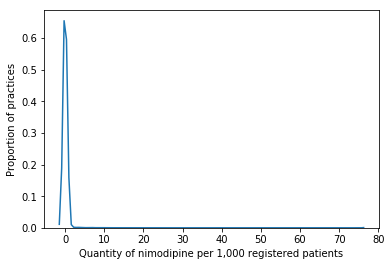

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.kdeplot(data["quantity_per_1000"], bw=0.5, legend=False)

plt.ylabel("Proportion of practices")
plt.xlabel("Quantity of nimodipine per 1,000 registered patients")

plt.show()

### Calculate percentage of practices with zero quantity per 1000

In [30]:
c = pd.DataFrame(data.groupby("quantity_per_1000")["practice"].count())
c / c.sum()

,practice
quantity_per_1000,
0.000000,0.991012
0.487101,0.000145
0.570389,0.000145
0.820996,0.000145
0.876150,0.000145
0.882321,0.000145
1.186838,0.000145
1.224847,0.000145
1.237569,0.000145


## get practice names to verify contact details

In [31]:
# Import dataset from BigQuery
from ebmdatalab import bq
GBQ_PROJECT_ID = '620265099307'

sql_prac = '''
SELECT code, name as practice_name, address1, address2, address3, address4, postcode FROM ebmdatalab.hscic.practices where setting = 4
'''

prac = bq.cached_read(sql_prac, csv_path='prac.csv', use_cache=False)  # add `use_cache=False` to override

prac.head()

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


,code,practice_name,address1,address2,address3,address4,postcode
0,A83048,ROCKLIFFE COURT SURGERY,THE SURGERY,ROCKLIFFE COURT,HURWORTH PLACE,"DARLINGTON, CO.DURHAM",DL2 2DS
1,Y02607,DARLINGTON HEALTH CENTRE,DR PIPER HOUSE,KING STREET,DARLINGTON,CO DURHAM,DL3 6JL
2,A83619,SOUTHDENE MEDICAL CENTRE,SOUTHDENE MEDICAL CENTRE,FRONT ST,SHOTTON COLLIERY,CO.DURHAM,DH6 2LT
3,A83638,SHILDON HEALTH CLINIC,SHILDON HEALTH CLINIC,CHURCH STREET,SHILDON,CO.DURHAM,DL4 1DU
4,A83032,WOODVIEW MEDICAL PRACTICE,THE SURGERY,COCKFIELD,BISHOP AUCKLAND,CO.DURHAM,DL13 5AF


In [36]:
contacts = agg[["practice","3-mo quantity per 1000"]].merge(prac, left_on="practice", right_on="code", how="left").drop("code",axis=1)
contacts.rename(columns={"3-mo quantity per 1000":"value"}, inplace=True)

contacts.to_csv("contacts_request.csv")

contacts

,practice,value,practice_name,address1,address2,address3,address4,postcode
0,A82036,8.831322,THE LAKES MEDICAL PRACTICE,PENRITH HEALTH CENTRE,BRIDGE LANE,PENRITH,CUMBRIA,CA11 8HW
1,A83047,60.491493,DENMARK STREET SURGERY,DENMARK STREET SURGERY,DENMARK STREET,DARLINGTON,COUNTY DURHAM,DL3 0PD
2,B82005,1.706630,PRIORY MEDICAL GROUP,PRIORY MEDICAL CENTRE,CORNLANDS ROAD,"ACOMB, YORK",NORTH YORKSHIRE,YO24 3WX
3,B86081,23.374997,BELLBROOKE SURGERY,BELLBROOKE SURGERY,"BELLBROOKE AVE, HAREHILLS",LEEDS,None,LS9 6AU
4,C81044,7.516913,WHITTINGTON MOOR SURGERY,WHITTINGTON MOOR SURGERY,SCARSDALE ROAD,WHITTINGTON MOOR,"CHESTERFIELD,DERBYSHIRE",S41 8NA
5,C81110,42.105263,WELLBROOK MEDICAL CENTRE,WELLBROOK MEDICAL CENTRE,"WELLAND ROAD, HILTON",DERBY,DERBYSHIRE,DE65 5GZ
6,C82027,3.699789,THE OLD SCHOOL SURGERY,THE OLD SCHOOL SURGERY,HINCKLEY ROAD,STONEY STANTON,LEICESTERSHIRE,LE9 4LJ
7,C82051,19.898140,NEWBOLD VERDON MED.PRACT.,NEWBOLD VERDON MED.PRACT.,ST GEORGES CLOSE,NEWBOLD VERDON,LEICESTERSHIRE,LE9 9PZ
8,C86007,13.807841,THE BURNS PRACTICE,THE BURNS PRACTICE,"4 ALBION PL, BENNETTHORPE",DONCASTER,SOUTH YORKSHIRE,DN1 2EG
9,C87015,64.045747,WICKERSLEY HEALTH CENTRE,WICKERSLEY HEALTH CENTRE,"POPLAR GLADE, WICKERSLEY",ROTHERHAM,None,S66 2JQ
